In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage import io, color
from skimage.io import imread_collection
from scipy.spatial import procrustes
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from scipy.spatial import procrustes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from scipy.spatial import procrustes
from scipy.stats import pearsonr

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install opencv-python

This shows a sample image of the rock from the 360 Rocks dataset

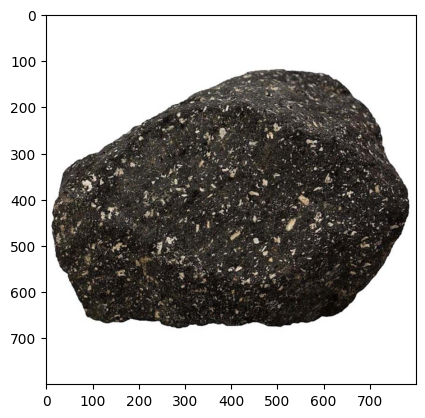

In [ ]:
plt.imshow(img)

Load dataset images mounted on the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#define the dataset path
dataset_path = '/content/drive/My Drive/360 Rocks'

In [ ]:
#read the images and labels
image_list=[]
labels = []
for filename in os.listdir(dataset_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(dataset_path, filename)
        image = cv2.imread(image_path) #read image
        image = cv2.resize(image, (400, 400))#resize the image to 400,400
        if image is not None:
            image_list.append(image)

    # Extract category from the filename (first letter I,M,S define the 3 types of rock)
    category = filename[0]
    if category == 'I':
        labels.append(0)
    elif category == 'M':
        labels.append(1)
    elif category == 'S':
        labels.append(2)


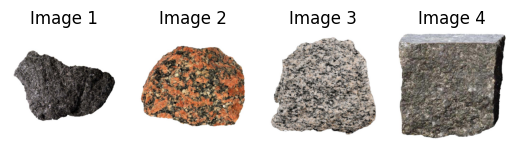

In [ ]:
# Display the first 4 images from loaded dataset without any preprocessing
num_images_to_display = 4

for i in range(min(num_images_to_display, len(image_list))):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.show()

In [ ]:
#no of images in the dataset
len(image_list)

360

In [ ]:
#the size of a single image
image_list[0].shape

(400, 400, 3)

Apply PCA to the images from folder '360 Rocks'. How many components do you need to preserve 95% of the variance? [3 points]

Standardize the data, first we convert it to gray scale images,flatten the image,scale it using standard scaler

In [ ]:
# convert images to grayscale
def convert_to_gray(images):
    gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
    return gray_images

# tandardize the data
def standardize_data(images):
    #flatten the data
    flattened_images = [img.flatten() for img in images]
    X = np.array(flattened_images)

    #scale the data using standard scaler
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)

    return X_standardized

In [ ]:
# Convert images to grayscale
gray_images = convert_to_gray(image_list)

# Standardize the grayscale images
X_standardized = standardize_data(gray_images)

In [ ]:
# Display the shape of the standardized data
print("Shape of standardized data array:", X_standardized.shape)

Shape of standardized data array: (360, 160000)


Original Images:


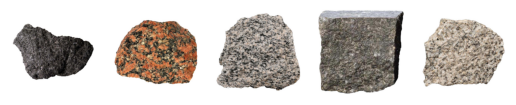

Standardized Images:


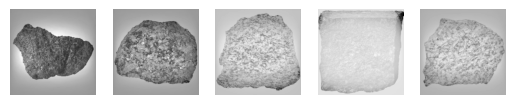

In [ ]:
# Print the first 5 original images
print("Original Images:")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

# Print the first 5 standardized images
print("Standardized Images:")
for i in range(5):
    # Reshape the flattened image back to its original shape
    standardized_img = X_standardized[i].reshape(gray_images[i].shape)
    plt.subplot(1, 5, i+1)
    plt.imshow(standardized_img, cmap='gray')
    plt.axis('off')
plt.show()

Apply PCA to the images from folder '360 Rocks'. How many components do you need to preserve 95% of the variance? [3 points]

In [ ]:
# Apply PCA to preseve 95% of the variance
pca = PCA(0.95)
X_pca = pca.fit_transform(X_standardized)

# Get the number of principal components
num_components = pca.components_.shape[0] # this is teh no of component required to retain 95% of variance

print(f"Number of principal components after PCA: {num_components}")
print("Explained variance ratio:",pca.explained_variance_ratio_.sum()  )

print(f"Number of components needed to preserve 95% of the variance: {num_components}")

Number of principal components after PCA: 215
Explained variance ratio: 0.9500087973752637
Number of components needed to preserve 95% of the variance: 215


In [ ]:
print(pca.n_components_)
print(pca.explained_variance_ratio_.sum())

215
0.9500087973752637


Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 95% of variance using PCA. [3 points]

In [ ]:
#inverese transform the images
X_reconstructed = pca.inverse_transform(X_pca)

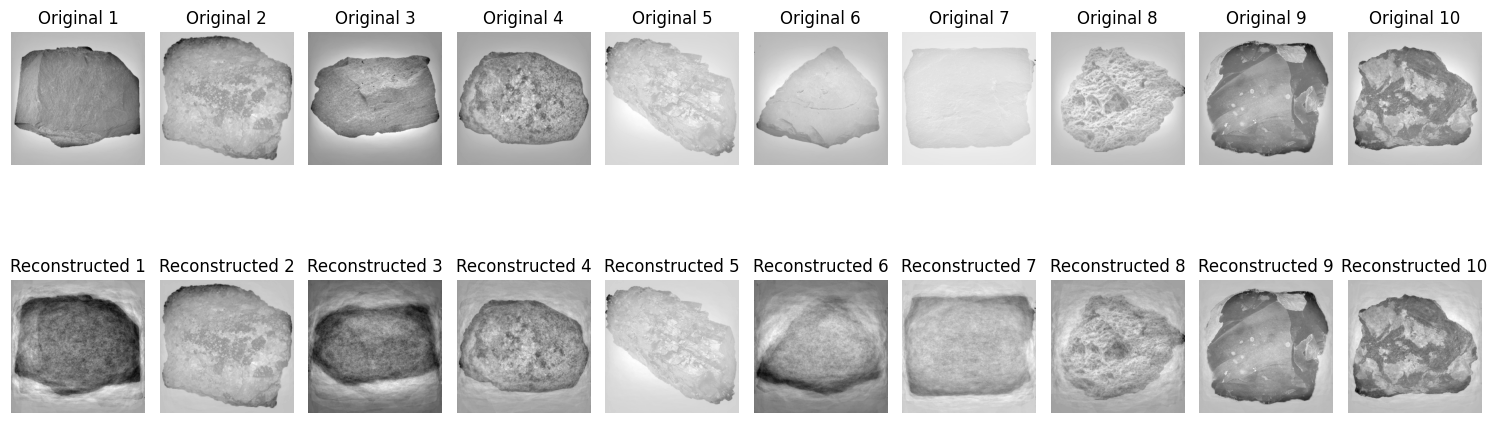

In [ ]:
# Select 10 images
selected_indices = np.random.choice(X_standardized.shape[0], size=10, replace=False)
selected_images = X_standardized[selected_indices]

# Assuming the images are square, find the side length
image_side_length = int(np.sqrt(selected_images.shape[1]))

# Plot Original Images
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(selected_images[i].reshape((image_side_length, image_side_length)), cmap='gray')
    plt.title(f'Original {i + 1}')
    plt.axis('off')

# Plot Reconstructed Images
reconstructed_images = pca.inverse_transform(X_pca[selected_indices])
for i in range(10):
    plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed_images[i].reshape((image_side_length, image_side_length)), cmap='gray')
    plt.title(f'Reconstructed {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

3. Each of the images belongs to one of three rock categories. The category is indicated by the first letter in the filename (I, M and S). We will now try to see if the visualization can help us identify different clusters.


A. Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components? [2 points].


In [ ]:
#using PCA to reduce dimenionality to only 2
pca2 = PCA(n_components=2)
images_2d = pca2.fit_transform(X_standardized)
variance_explained = np.sum(pca2.explained_variance_ratio_)

In [ ]:
images_2d.shape

(360, 2)

In [ ]:
variance_explained

0.3155612322998621

In [ ]:
# Apply PCA with 2 components
# images_2d, variance_explained = apply_pca(X_standardized, num_components=2)

print(f"Variance explained by the first two principal components: {variance_explained * 100:.2f}%")

Variance explained by the first two principal components: 31.56%


It shows that the 1st 2 component have a total variance of 31.56% of the image.

B. Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image category (so you will have three different colors). Then add some rock images to the visualization to better understand what features in the images are accounting for the majority of variance in the data (your visualization should look similar to the one after line 71 in this file https://github.com/ageron/handson-ml3/blob/main/08_dimensionality_reduction.ipynbLinks to an external site. but with images of rocks instead of MNIST digits). Repeat the process and create the same type of plots for t-SNE, LLE and MDS. [6 points]


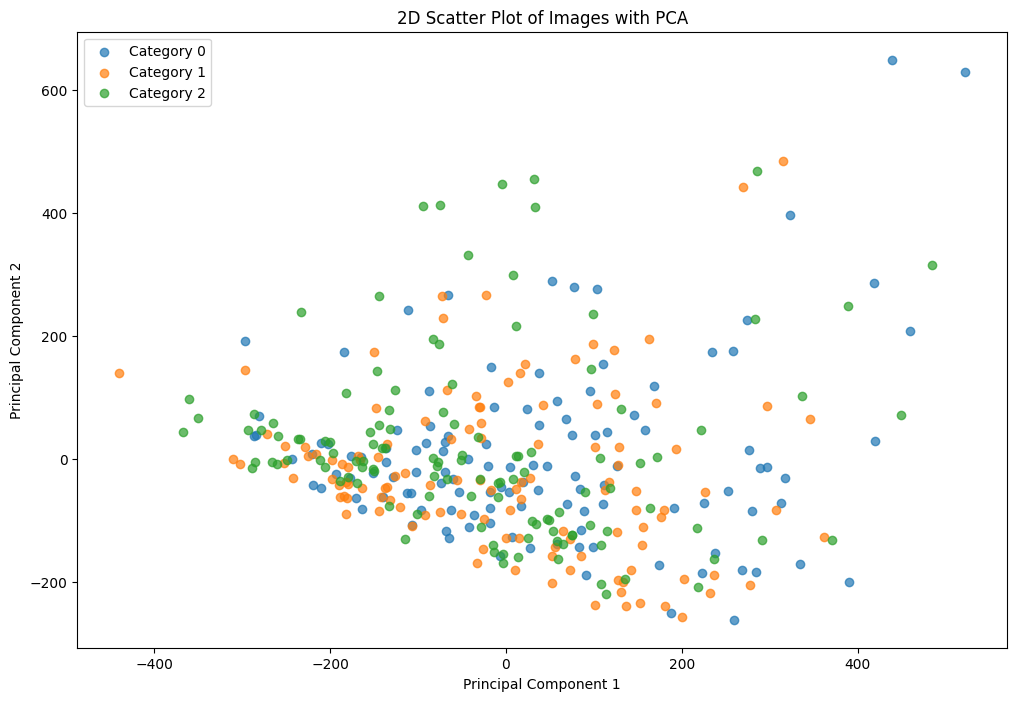

In [ ]:
# 2D scatter plot for PCA
plt.figure(figsize=(12, 8))
for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(images_2d[indices, 0], images_2d[indices, 1], label=f'Category {label}', alpha=0.7)

plt.title('2D Scatter Plot of Images with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [ ]:
# Function to visualize images in 2D space
def visualize_2d_embedding(embedding, labels, title):
    plt.figure(figsize=(12, 8))
    for label in np.unique(labels):
        indices = np.where(labels == label)
        plt.scatter(embedding[indices, 0], embedding[indices, 1], label=f'Category {label}', alpha=0.7)

    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

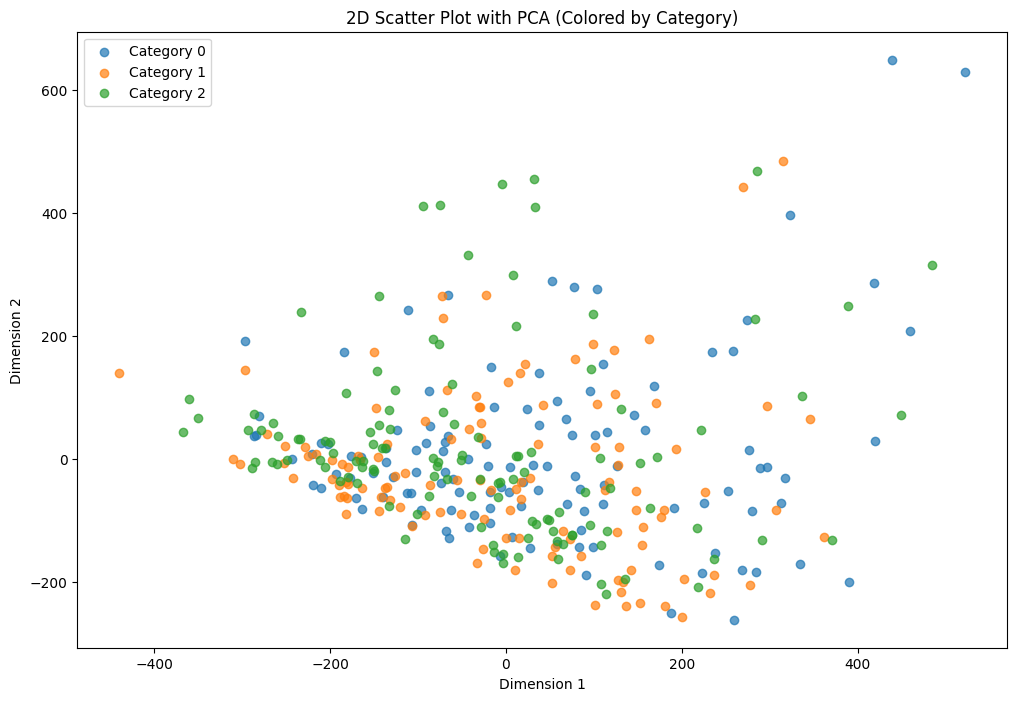

In [ ]:
# Visualize PCA embedding
visualize_2d_embedding(images_2d, labels, '2D Scatter Plot with PCA (Colored by Category)')

In [ ]:
# function for scatter plot with images
def scatter_plot_with_images(embeddings, labels, image_list, title):
    plt.figure(figsize=(12, 8))

    for category in np.unique(labels):
        indices = labels == category
        plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=category)

    # Add rock images to the plot
    ax = plt.gca()
    for i, label in enumerate(labels):
        if i < len(image_list):  # To ensure we have images for each point
            imagebox = OffsetImage(image_list[i], zoom=0.04)
            ab = AnnotationBbox(imagebox, (embeddings[i, 0], embeddings[i, 1]), frameon=False, pad=0)
            ax.add_artist(ab)

    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

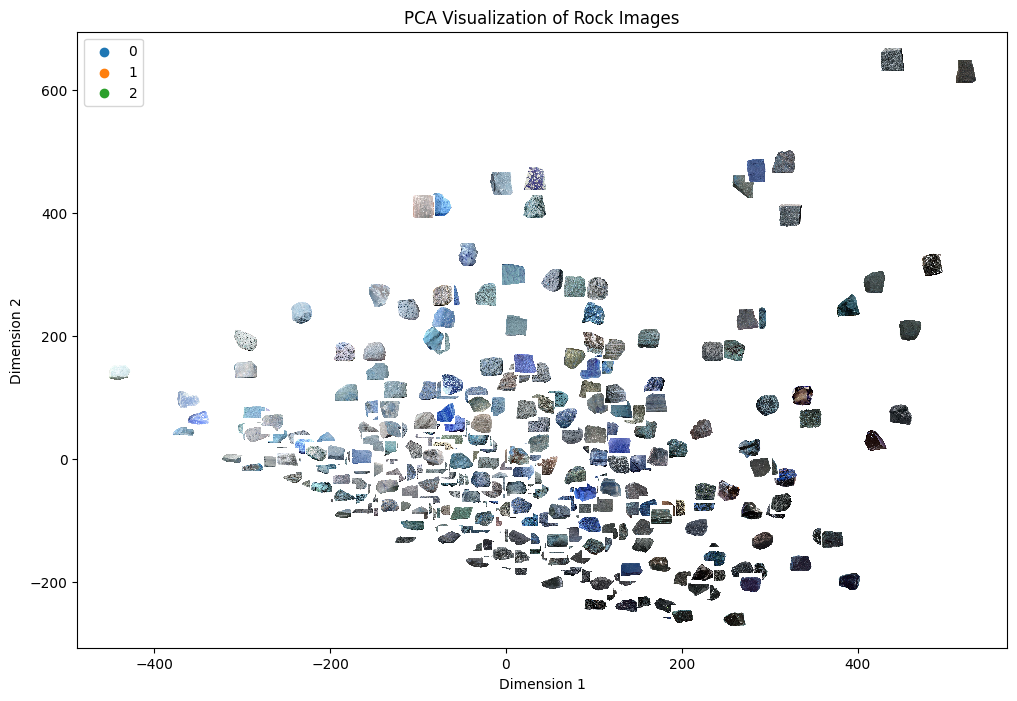

In [ ]:
# Apply PCA
scatter_plot_with_images(images_2d, labels, image_list, 'PCA Visualization of Rock Images')

Observation: The clustering on the 1st level is prominently influenced by the color of the rocks. Lighter-colored rocks are positioned on the left-hand side, gradually transitioning towards darker hues as we move to the right. This color gradient is particularly evident in the range from blue on the left to other shades on the right. The arrangement suggests a visual progression from lighter to darker colors and a noticeable shift in the color spectrum from left to right.

In [ ]:
def scatter_plot_and_overlayed_images(embeddings, labels, image_list, title, zoom=0.05):
    plt.figure(figsize=(14, 10))  # Increase the figure size

    # Scatter plot with images
    for i, label in enumerate(labels):
        if i < len(image_list):  # To ensure we have images for each point
            imagebox = OffsetImage(image_list[i], zoom=zoom)
            ab = AnnotationBbox(imagebox, (embeddings[i, 0], embeddings[i, 1]), frameon=False, pad=0)
            plt.gca().add_artist(ab)

    # Scatter plot without images
    for label in np.unique(labels):
        indices = np.where(labels == label)
        plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=f'Category {label}', alpha=0.7, zorder=10)  # Set zorder to ensure scatter plot is on top

    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()

    # Show the combined plot
    plt.show()

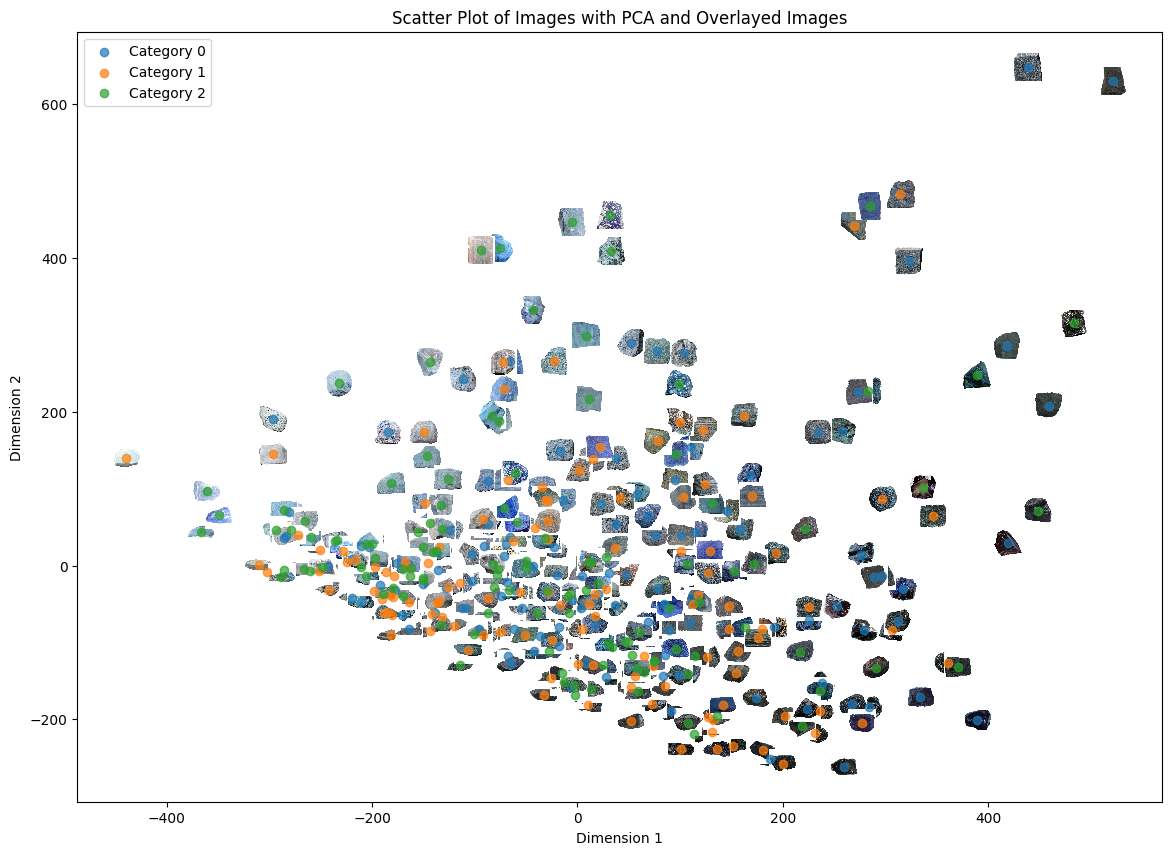

In [ ]:
scatter_plot_and_overlayed_images(images_2d,labels,image_list,'Scatter Plot of Images with PCA and Overlayed Images')

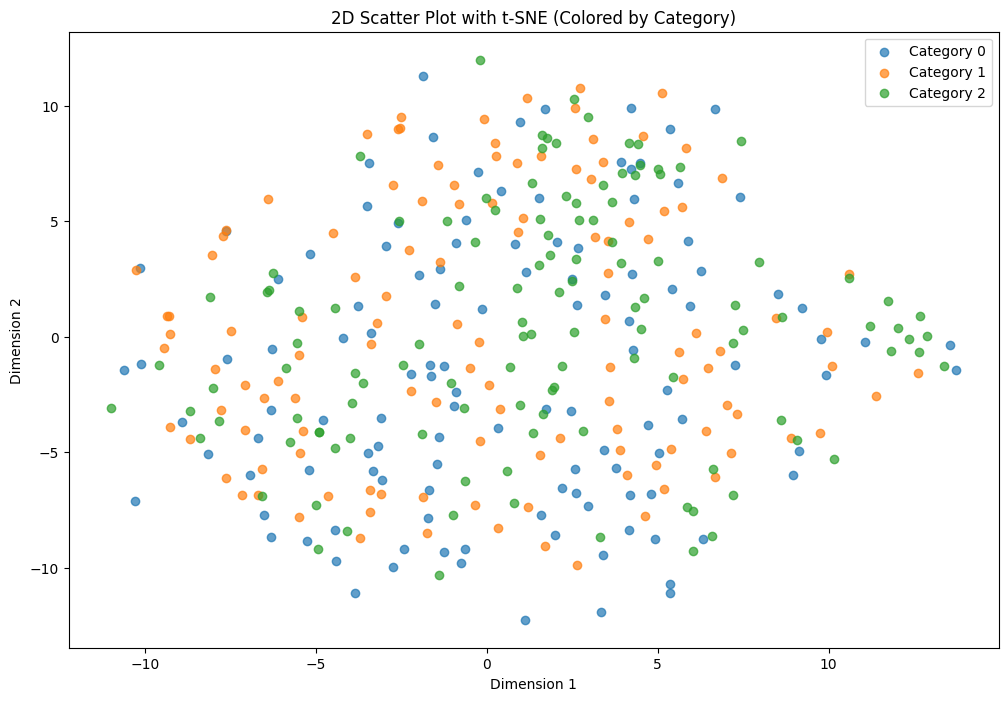

In [ ]:
# Apply t-SNE with 2 components
tsne = TSNE(n_components=2)
images_2d_tsne = tsne.fit_transform(X_standardized)

# Visualize t-SNE embedding
visualize_2d_embedding(images_2d_tsne, labels, '2D Scatter Plot with t-SNE (Colored by Category)')


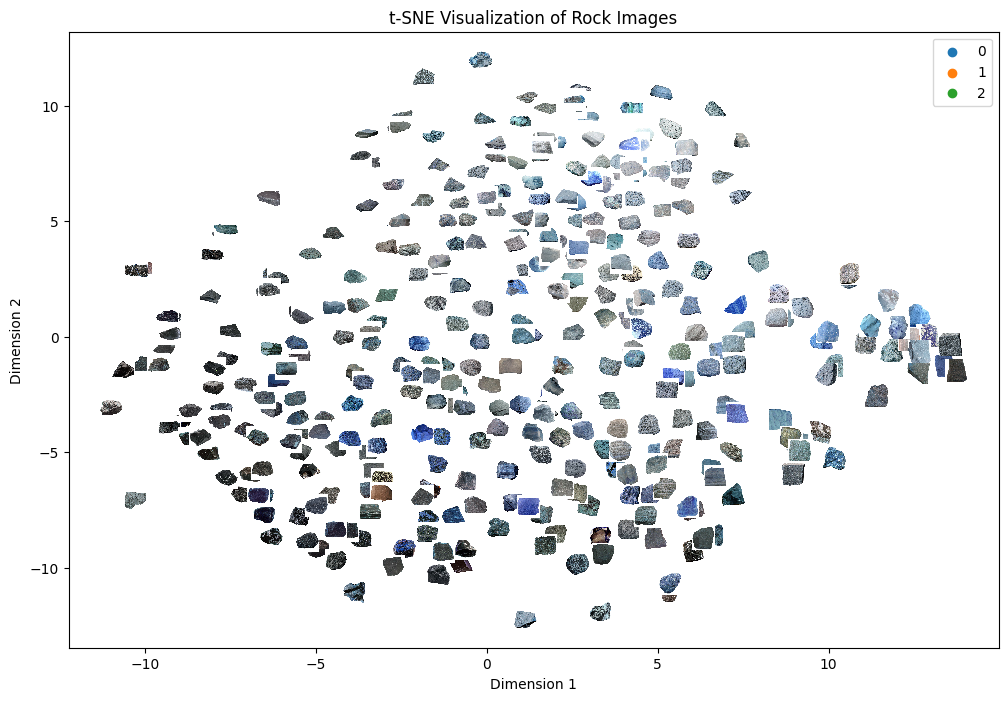

In [ ]:
# Apply t-SNE
scatter_plot_with_images(images_2d_tsne, labels, image_list, 't-SNE Visualization of Rock Images')

Observation: The clustering on the 1st level is prominently influenced by the color of the rocks. Lighter-colored rocks are positioned on the right-hand upper side, gradually transitioning towards darker hues as we move to the left down. This color gradient is particularly evident in the range from blue. The arrangement suggests a visual progression from lighter to darker colors and a noticeable shift in the color spectrum from left to right.</br>
other observation is with the corse type of rocks(the texture of rocks) smotter rocks towards the left down corner

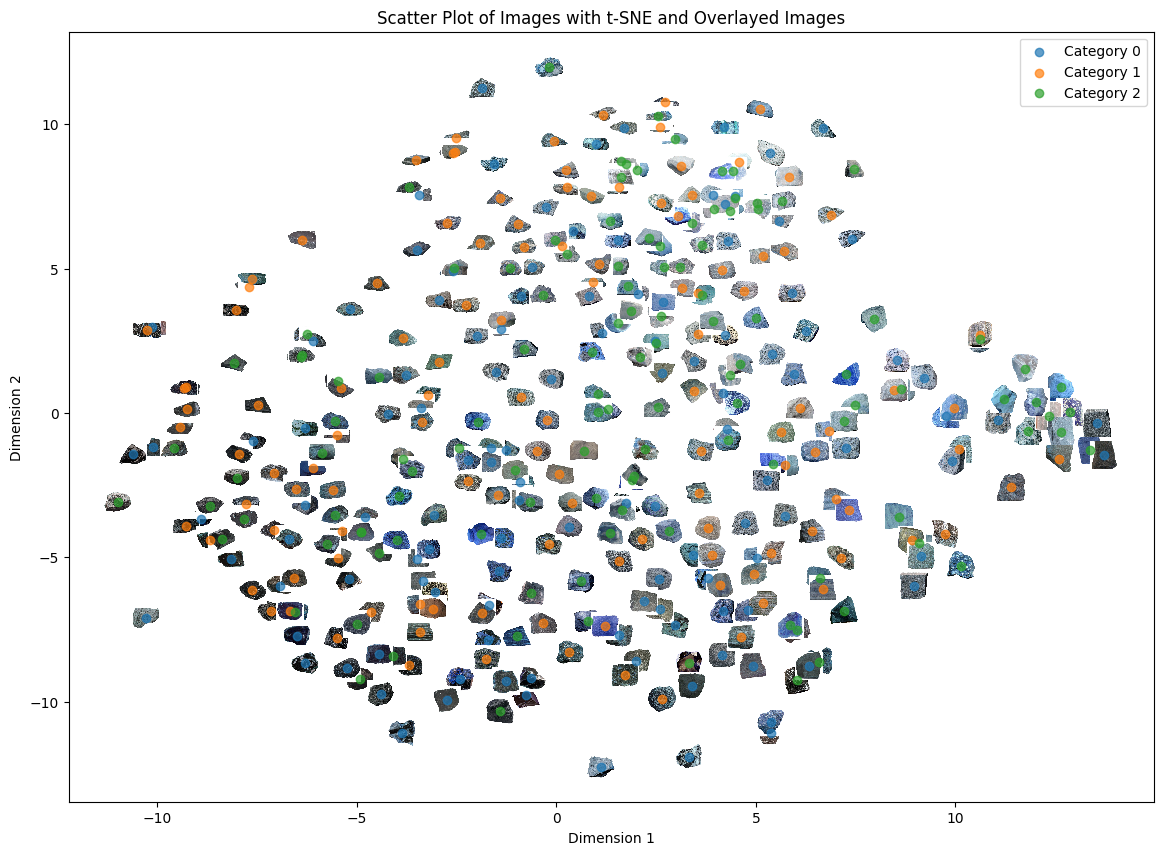

In [ ]:
scatter_plot_and_overlayed_images(images_2d_tsne, labels, image_list, 'Scatter Plot of Images with t-SNE and Overlayed Images')

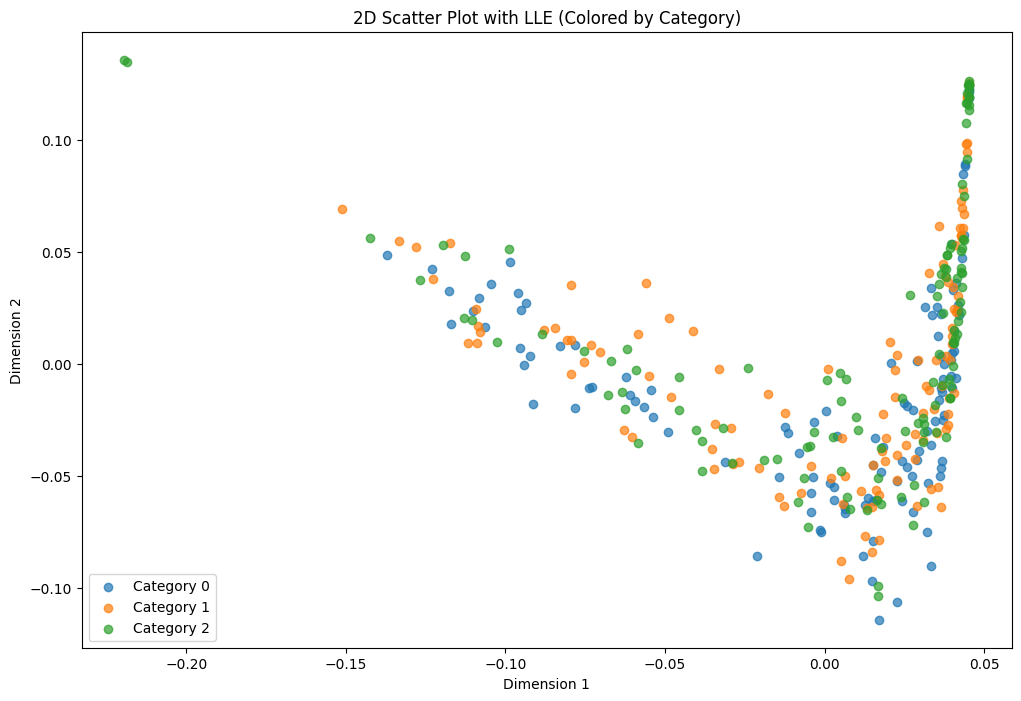

In [ ]:
# Apply LLE with 2 components
lle = LocallyLinearEmbedding(n_components=2)
images_2d_lle = lle.fit_transform(X_standardized)

# Visualize LLE embedding
visualize_2d_embedding(images_2d_lle, labels, '2D Scatter Plot with LLE (Colored by Category)')

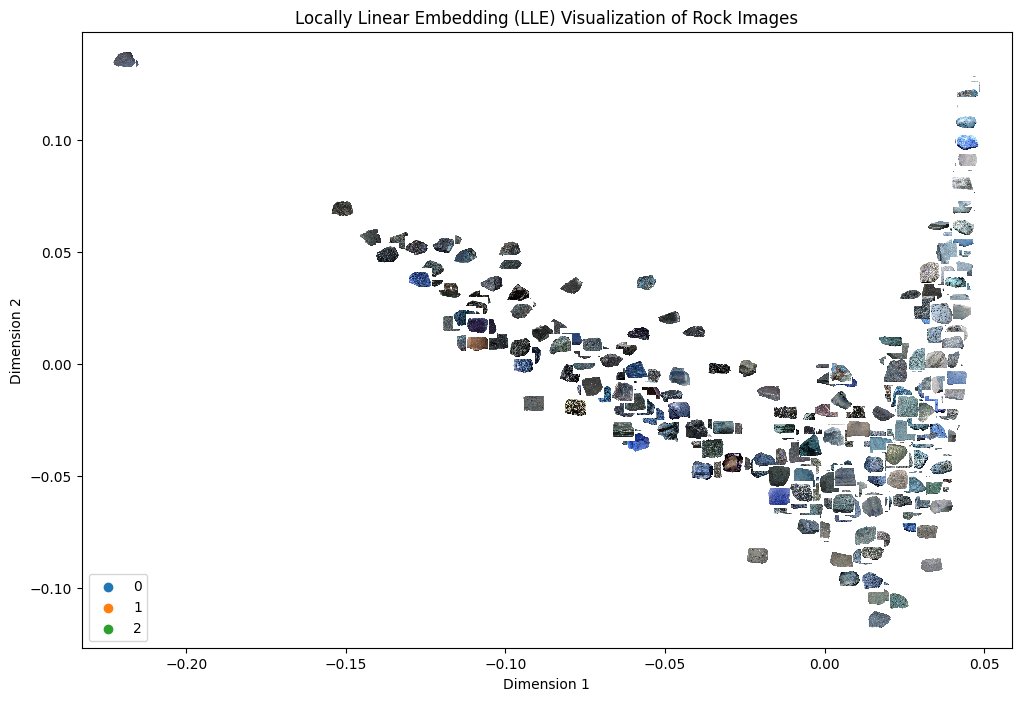

In [ ]:
scatter_plot_with_images(images_2d_lle, labels, image_list, 'Locally Linear Embedding (LLE) Visualization of Rock Images')

Observation: The clustering by LLE on the 1st level is prominently influenced by the color of the rocks. Lighter-colored rocks are positioned on the right-hand side, gradually transitioning towards darker hues as we move to the right. This color gradient is particularly evident in the range from blue on the left to other shades on the right.

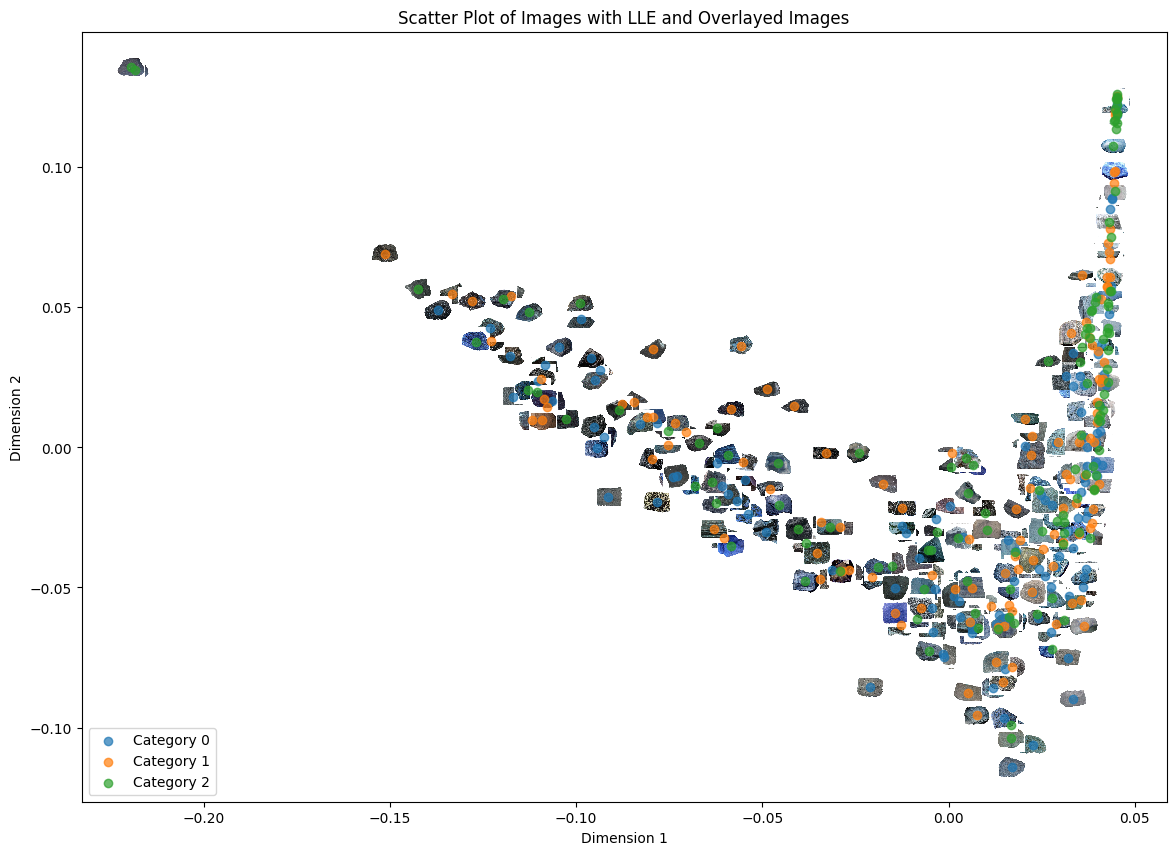

In [ ]:
scatter_plot_and_overlayed_images(images_2d_lle, labels, image_list, 'Scatter Plot of Images with LLE and Overlayed Images')

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


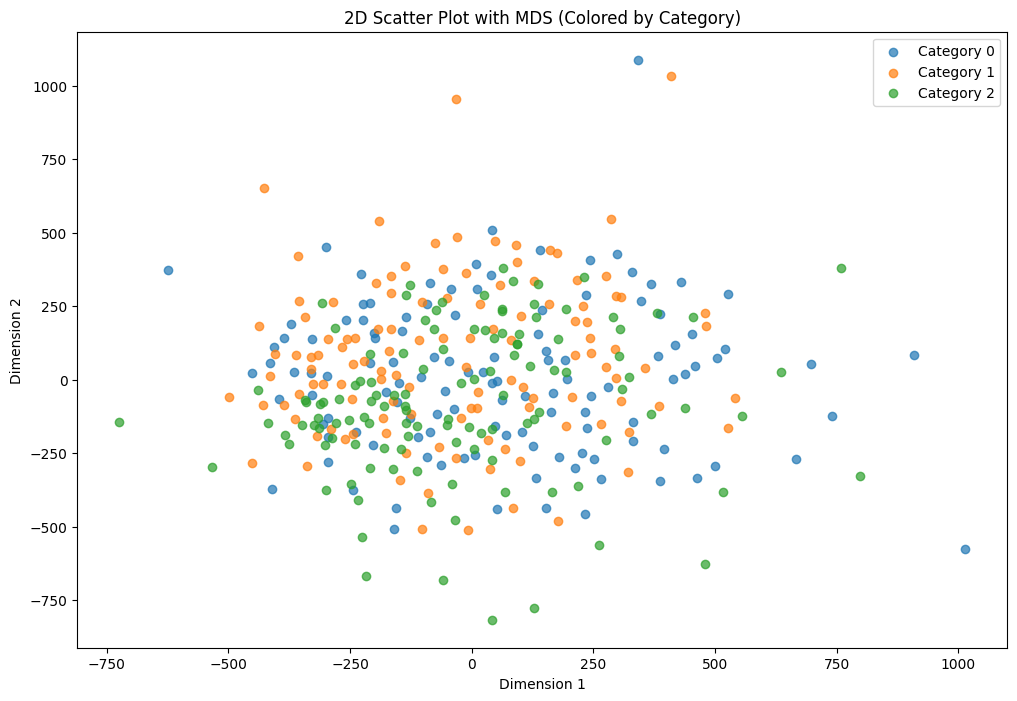

In [ ]:
# Apply MDS with 2 components
mds = MDS(n_components=2,random_state=42)
images_2d_mds = mds.fit_transform(X_standardized)

# Visualize MDS embedding
visualize_2d_embedding(images_2d_mds, labels, '2D Scatter Plot with MDS (Colored by Category)')

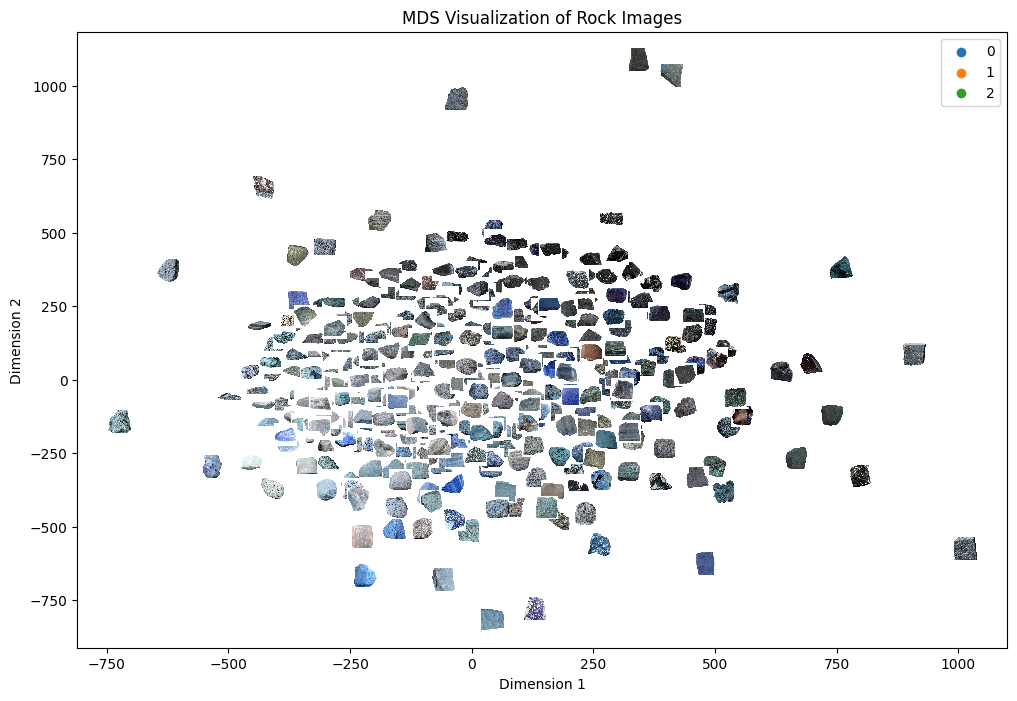

In [ ]:
scatter_plot_with_images(images_2d_mds, labels, image_list, 'MDS Visualization of Rock Images')

Observation: The clustering by MDS on the 1st level is prominently influenced by the color of the rocks. Lighter-colored rocks are positioned on the left-hand down side, gradually transitioning towards darker hues as we move to the right.

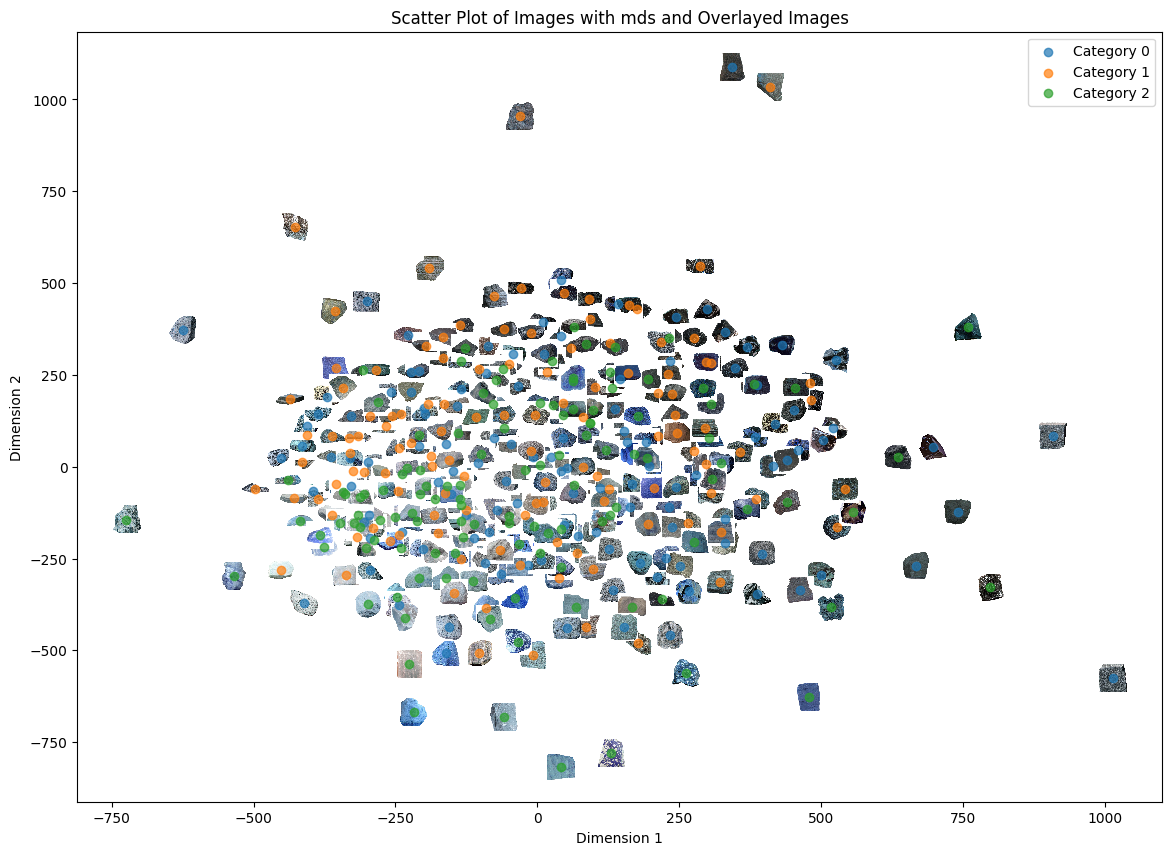

In [ ]:
scatter_plot_and_overlayed_images(images_2d_mds, labels, image_list, 'Scatter Plot of Images with mds and Overlayed Images')

C. Which of the visualizations do you prefer?[1 point] </br>
Ans: PCA gives a better visualization of the data difference on basis of color of the rock

4. Now let's see if these dimensionality reduction techniques can give us similar features to those that humans use to judge the images. File mds_360.txt contains 8 features for each of the images (rankings are in the same order as the images in  '360 Rocks' folder. Run PCA, t-SNE, LLE and MDS to reduce the dimensionality of the images to 8. Then, compare those image embeddings with the ones from humans that are in the mds_360.txt file. Use Procrustes analysis to do the comparison (here is one example of how to do that mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_pca_embeddings_data). Here matrix_with_human_data and matrix_with_pca_embeddings_data should be 360 by 8. disparity will tell you the difference in the data. Report disparity for each of the four dimensionality reduction methods. Compute the correlation coefficient between each dimension of mtx1 and mtx2 for each of the four methods - display results in a table. [7 points]

In [ ]:
#dtaset path in drive
dataset_path = '/content/drive/My Drive/mds_360.txt'

In [ ]:
#read data
mds_features = np.loadtxt(dataset_path)

In [ ]:
print(mds_features)
print("size:",mds_features.shape)

[[-3.743 -1.204  2.001 ... -1.992  4.95   1.695]
 [ 2.332  1.625  0.985 ...  0.093  6.724  0.708]
 [ 0.346  1.49  -3.795 ... -3.786  0.706 -2.854]
 ...
 [-3.475 -3.431 -2.184 ... -2.265  1.129 -1.201]
 [-0.051 -2.358  1.994 ...  7.268 -0.593 -1.432]
 [ 1.134 -4.9    0.983 ...  4.695  0.624 -1.195]]
size: (360, 8)


In [ ]:
#scale it
scaler = MinMaxScaler()
pca3_result = scaler.fit_transform(mds_features)

#PCA
# pca3 = PCA(n_components=8)
# pca3_result = pca3.fit_transform(scaled_features)

# Check if the dimensionality is 360, 8
print(pca3_result.shape)

(360, 8)


Here we are preserving the shape to (360, 8),which is expected

In [ ]:
#convert to df
import pandas as pd
pca_df = pd.DataFrame(data=pca3_result, columns=[f'PC{i}' for i in range(1, 9)])

In [ ]:
#this is the dataframe of mds_360.txt after preprocessing it
pca_df

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    0.148973 -0.271543 -0.210174 -0.056461 -0.013740 -0.226502  0.241761   
1   -0.366037 -0.040398 -0.175295  0.003709 -0.145708 -0.330163  0.169538   
2    0.107073  0.087783 -0.236575  0.146396 -0.162892  0.079627 -0.214500   
3   -0.196952 -0.023984 -0.031455 -0.124897  0.039050 -0.206395 -0.208329   
4   -0.215349 -0.183331 -0.382941  0.063815  0.054252  0.138522 -0.241435   
..        ...       ...       ...       ...       ...       ...       ...   
355  0.200942  0.237105  0.128021 -0.394985 -0.193296 -0.128676 -0.143873   
356  0.198905 -0.006845  0.108523 -0.285493  0.202301  0.141416 -0.230530   
357  0.365727  0.123286 -0.204908 -0.128429 -0.039306 -0.075794 -0.024804   
358 -0.118309  0.165029  0.313258 -0.358635 -0.138134  0.098369 -0.020646   
359 -0.069406  0.372758  0.188575 -0.294569 -0.012419 -0.204090 -0.022395   

          PC8  
0    0.044887  
1   -0.170192  
2   -0.339811  
3   -0.219381  
4   -0.127352  
..        ...  
355 -0.009849  
356 -0.051224  
357 -0.087695  
358  0.240452  
359  0.147340  

[360 rows x 8 columns]

Run PCA, t-SNE, LLE and MDS to reduce the dimensionality of the images to 8.

In [ ]:
# Run PCA
pca8 = PCA(n_components=8)
X_pca_8 = pca8.fit_transform(X_standardized)

# Run t-SNE
tsne8 = TSNE(n_components=8,method="exact")
X_tsne_8 = tsne8.fit_transform(X_standardized)

# Run LLE
lle8 = LocallyLinearEmbedding(n_components=8)
X_lle_8 = lle8.fit_transform(X_standardized)

# Run MDS
mds8 = MDS(n_components=8)
X_mds_8 = mds8.fit_transform(X_standardized)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [ ]:
print("X_pca_8 size:",X_pca_8.shape)
print("X_tsne_8 size:",X_tsne_8.shape)
print("X_lle_8 size:",X_lle_8.shape)
print("X_mds_8 size:",X_mds_8.shape)

X_pca_8 size: (360, 8)
X_tsne_8 size: (360, 8)
X_lle_8 size: (360, 8)
X_mds_8 size: (360, 8)


We have successfully transformed the images into an 8-dimensional space using all four methods. The resulting representations for each method have a final shape of (360, 8), indicating that we now have 360 data points, each described by an 8-dimensional feature vector.







In [ ]:
#Then, compare those image embeddings with the ones from humans that are in the mds_360.txt file. Use Procrustes analysis to do the comparison
mtx1_pca, mtx2_pca,disparity_pca = procrustes(pca_df, X_pca_8)
mtx1_tsne, mtx2_tsne,disparity_tsne = procrustes(pca_df, X_tsne_8)
mtx1_lle, mtx2_lle,disparity_lle = procrustes(pca_df, X_lle_8)
mtx1_mds, mtx2_mds,disparity_mds = procrustes(pca_df, X_mds_8)

In [ ]:
correlation_pca = np.corrcoef(mtx1_pca.T, mtx2_pca.T)[0, 8:]
correlation_tsne = np.corrcoef(mtx1_tsne.T, mtx2_tsne.T)[0, 8:]
correlation_lle = np.corrcoef(mtx1_lle.T, mtx2_lle.T)[0, 8:]
correlation_mds = np.corrcoef(mtx1_mds.T, mtx2_mds.T)[0, 8:]

In [ ]:
import pandas as pd
data = {
    'Method': ['PCA', 't-SNE', 'LLE', 'MDS'],
    'Disparity': [disparity_pca, disparity_tsne, disparity_lle, disparity_mds],
    'Correlation Coefficients': [
        correlation_pca.tolist(),
        correlation_tsne.tolist(),
        correlation_lle.tolist(),
        correlation_mds.tolist()
    ]
}

df = pd.DataFrame(data)
print(df)

  Method  Disparity                           Correlation Coefficients
0    PCA   0.980285  [0.19703211644420487, -0.019186604302878253, -...
1  t-SNE   0.993709  [0.07941839287424157, 0.04459460120886979, 0.0...
2    LLE   0.984321  [0.15299818823822678, -0.011334987984790027, -...
3    MDS   0.978866  [0.2298268760571698, -0.002855766450926172, -0...


In [ ]:
from tabulate import tabulate #display as a table
print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))

+--------+--------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Method |     Disparity      |                                                                               Correlation Coefficients                                                                               |
+--------+--------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|  PCA   | 0.9802845128719879 | [0.19703211644420487, -0.019186604302878253, -0.03716095316949998, -0.00046030206895907207, -0.0036977456051592097, 0.02476031223478242, 0.013566729544532788, -0.04668911393024565] |
| t-SNE  | 0.9937094620656017 |    [0.07941839287424157, 0.04459460120886979, 0.0017568143061688526, 0.030735284163826915, 0.041828200561565

**Observations:**
*  PCA has the lowest displarity value which indicates that it relatively better alignment between the original human data and the PCA-transformed data than other methods.
*  The correlation cofficent table shows that the 1stcomponent has a better correlation than the following components.So the 1st component is much more imp than others





5.Cluster the 360 images using K-Means.


A.To speed up the algorithm, use PCA to reduce the dimensionality of the dataset to two. Determine the number of clusters using one of the techniques we discussed in class. [4 points]


To determine the number of clusters in our dataset, we have used the "elbow method." and "silhouette methode".</br>
1. The elbow methode shows,optimal cluster size as 3</br>
2. The Silhouette method shows optimal cluster as 4


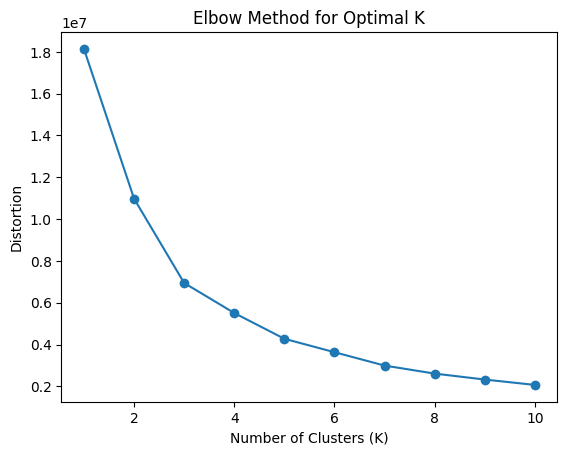

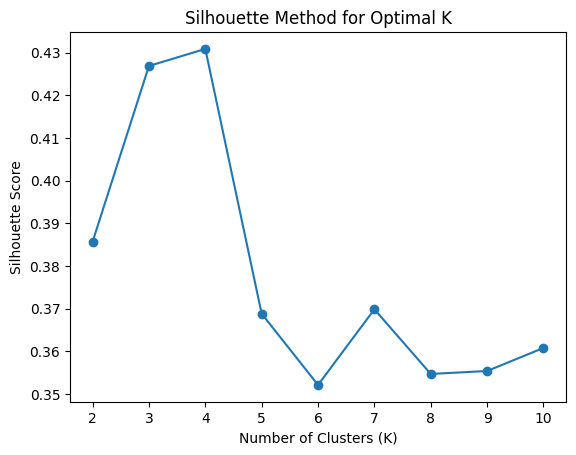

In [ ]:
distortions = []
max_clusters = 10
silhouette_scores = []
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init="random", random_state=42)
    cluster_labels = kmeans.fit_predict(images_2d)
    distortions.append(kmeans.inertia_)
    if i>1:
        silhouette_scores.append(silhouette_score(images_2d, cluster_labels))

plt.plot(range(1, max_clusters + 1), distortions, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.show()

plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(images_2d)
                for k in range(1, 10)]

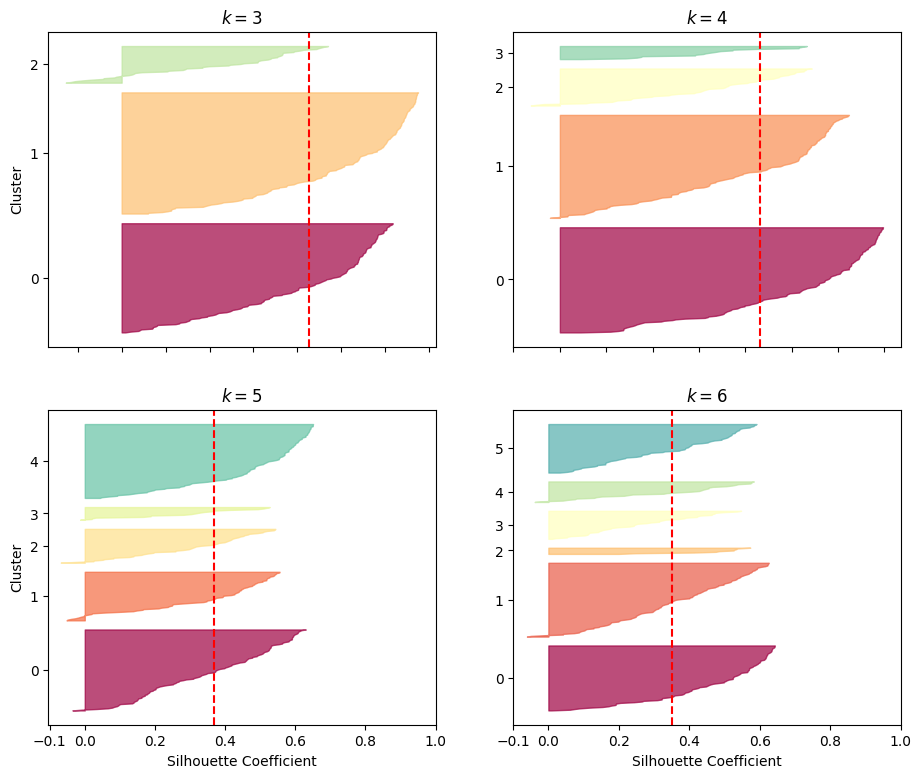

In [ ]:
# we will take a look at the silhouette plot to detmine the correct score of cluster
from matplotlib.ticker import FixedLocator, FixedFormatter
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(images_2d, y_pred)

    padding = len(images_2d) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

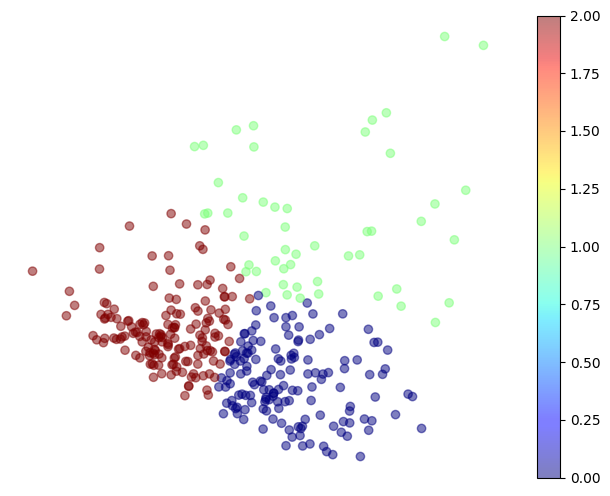

In [ ]:
#plot a 2d cluster
optimal_k = 3
kmeans1 = KMeans(n_clusters=optimal_k, init="random", random_state=42)
clusters = kmeans1.fit_predict(images_2d)

plt.figure(figsize=(8, 6))
plt.scatter(images_2d[:,0], images_2d[:, 1],
            c=clusters, cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

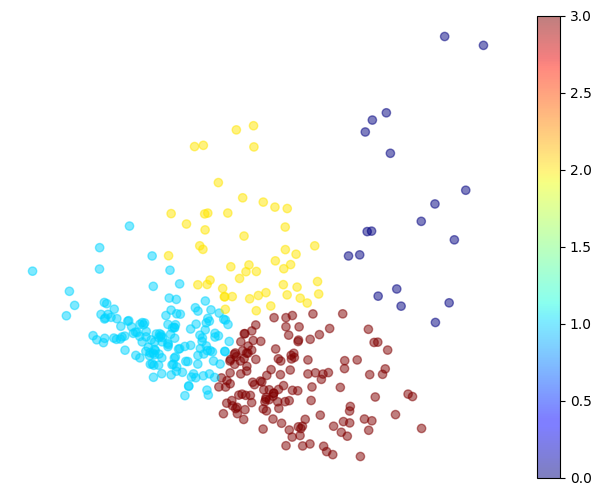

In [ ]:
#plot a 2d cluster
optimal_k = 4
kmeans2 = KMeans(n_clusters=optimal_k, init="random", random_state=42)
clusters = kmeans2.fit_predict(images_2d)

plt.figure(figsize=(8, 6))
plt.scatter(images_2d[:,0], images_2d[:, 1],
            c=clusters, cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

B.Visualize the clusters in a similar way to the visualization after line 28 here: https://github.com/ageron/handson-ml3/blob/main/09_unsupervised_learning.ipynbLinks to an external site., but color each dot based on the clusters it belongs to using the labels taken from the filename as in question 3  (I, M and S). [4 points]

In [ ]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, labels, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plt.scatter(X[:, 0], X[:, 1], c=[label for label in labels], cmap='viridis', edgecolors='k', marker='o', s=50, alpha=0.7)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

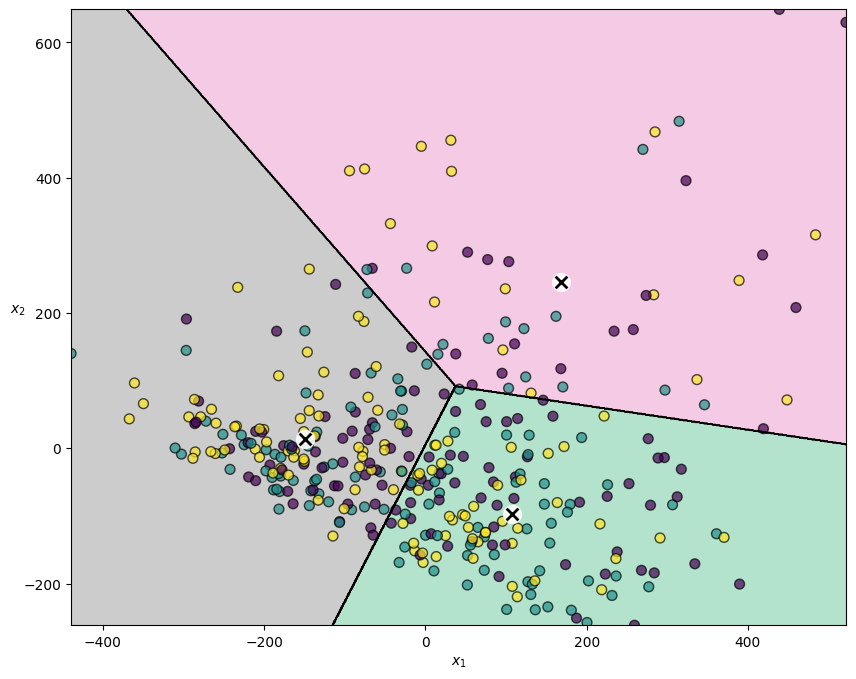

In [ ]:
plt.figure(figsize=(10, 8))
plot_decision_boundaries(kmeans1, labels, images_2d)
plt.show()

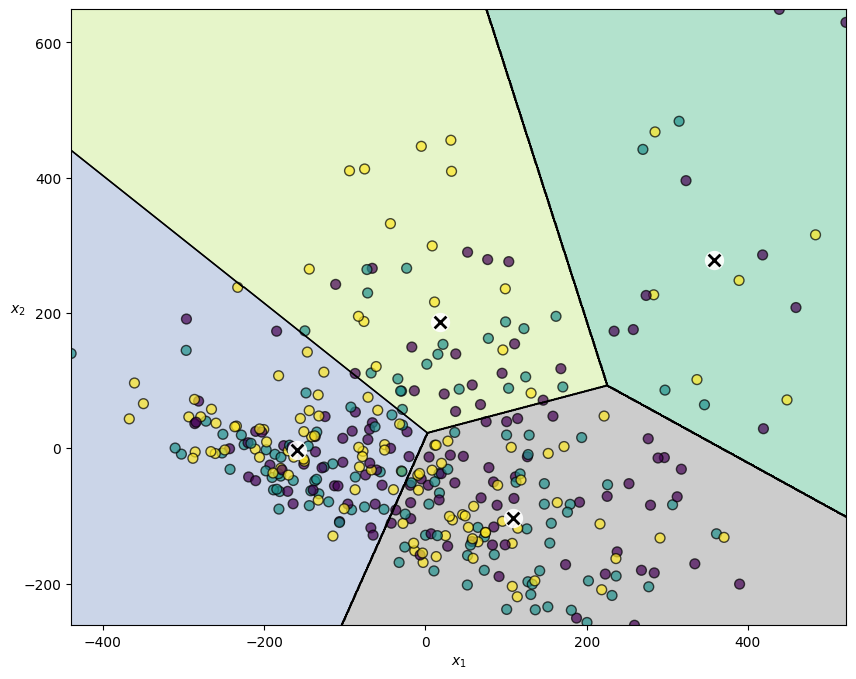

In [ ]:
plt.figure(figsize=(10, 8))
plot_decision_boundaries(kmeans2, labels, images_2d)
plt.show()

Optimal number of cluster is 4,based on the silhouette plot.

Voronoi plots are graphical representations of regions in a space that are closest to a specific set of points. They help visualize the partitions of space based on the proximity to each data point. Each point in the plot is associated with a specific region, and the boundary between adjacent regions is equidistant from the two nearest data points.Here we have ploted the dots according to class colors

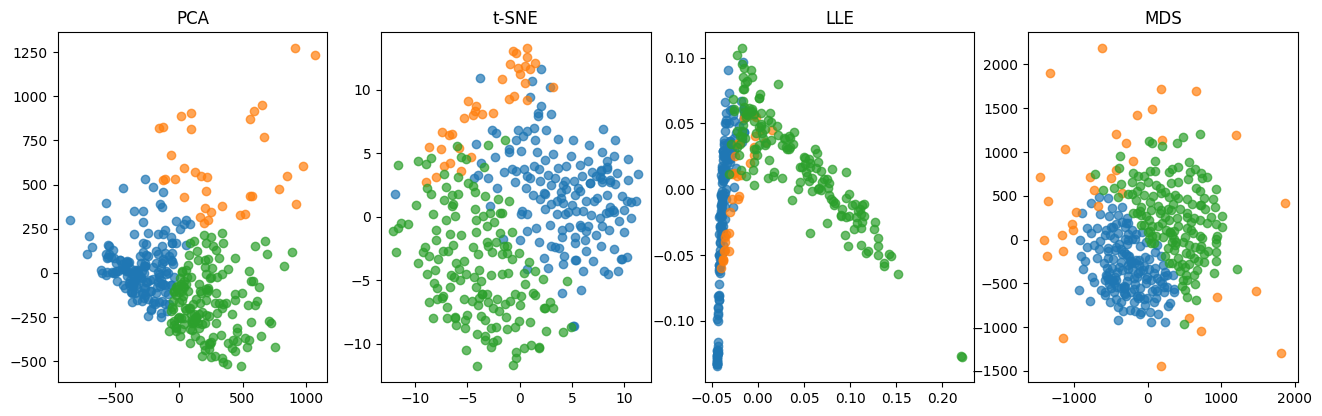

In [ ]:
# Visualize the results
plt.figure(figsize=(16, 10))

# PCA
plt.subplot(2, 4, 1)
for i in range(3):
    indices = np.where(cluster_labels == i)
    plt.scatter(images_2d[indices, 0], images_2d[indices, 1], label=f'Cluster {i}', alpha=0.7)
plt.title('PCA')

# t-SNE
plt.subplot(2, 4, 2)
for i in range(3):
    indices = np.where(cluster_labels == i)
    plt.scatter(images_2d_tsne[indices, 0], images_2d_tsne[indices, 1], label=f'Cluster {i}', alpha=0.7)
plt.title('t-SNE')

# LLE
plt.subplot(2, 4, 3)
for i in range(3):
    indices = np.where(cluster_labels == i)
    plt.scatter(images_2d_lle[indices, 0], images_2d_lle[indices, 1], label=f'Cluster {i}', alpha=0.7)
plt.title('LLE')

# MDS
plt.subplot(2, 4, 4)
for i in range(3):
    indices = np.where(cluster_labels == i)
    plt.scatter(images_2d_mds[indices, 0], images_2d_mds[indices, 1], label=f'Cluster {i}', alpha=0.7)
plt.title('MDS')

plt.show()


extra- clustering dispaly of all 4 dim-reduction after Kmeans algo.

6.Cluster the 360 images using EM.

A.Same as in the previous question, to speed up the algorithm, use PCA to reduce the dimensionality of the dataset to two. Determine the number of clusters using one of the techniques we discussed in class. [4 points]

For EM algorithm we consider Bayesian Information Criterion (BIC) to detmine the optimal number of cluster and the least value (min) is choosen to be the number of clusters

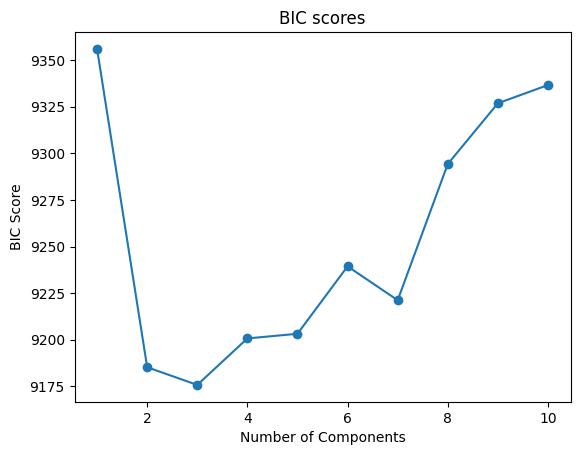

In [ ]:
bic_scores = []
max_components = 10

for i in range(1, max_components + 1):
    gmm = GaussianMixture(n_components=i, random_state=42)
    gmm.fit(images_2d)
    bic_scores.append(gmm.bic(images_2d))

# Plot the Elbow Method
plt.plot(range(1, max_components + 1), bic_scores, marker='o')
plt.title('BIC scores')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.show()

Upon applying the Bayesian Information Criterion (BIC) to the Expectation-Maximization (EM) algorithm with Principal Component Analysis (PCA) dimensionality reduction, we observed that the BIC scores were minimized when the number of clusters = 3. This implies that, based on the balance between model fit and complexity, the most suitable configuration for clustering was achieved with three clusters.

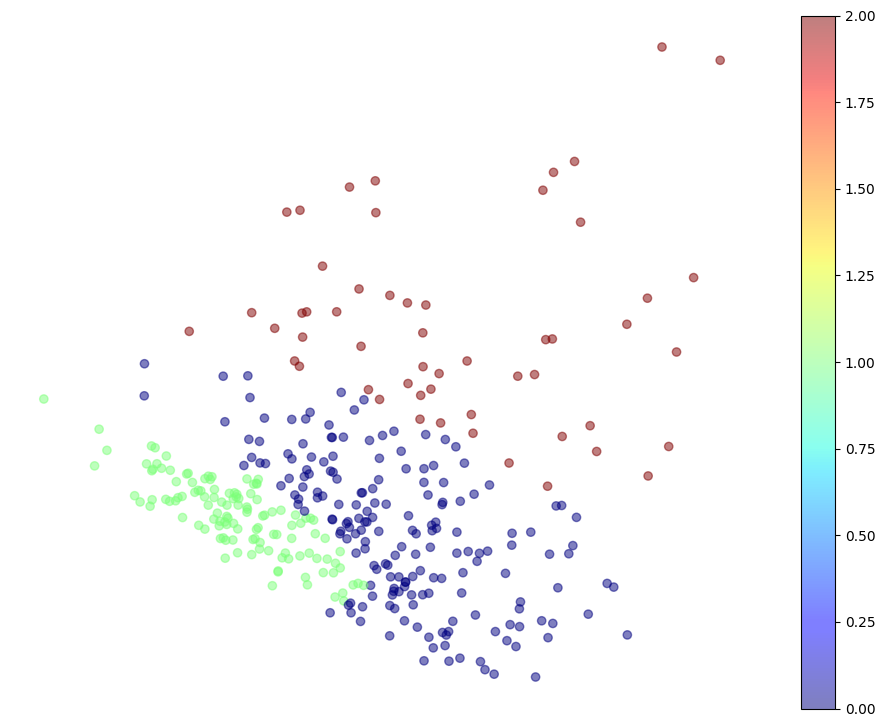

In [ ]:
optimal_components = 3  #define optimal component

gmm1 = GaussianMixture(n_components=optimal_components, random_state=42)
clusters = gmm1.fit_predict(images_2d)

plt.figure(figsize=(12, 9))
plt.scatter(images_2d[:,0], images_2d[:, 1],
            c=clusters, cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

B.Visualize the clusters in a similar way to the visualization after line 28 here: https://github.com/ageron/handson-ml3/blob/main/09_unsupervised_learning.ipynbLinks to an external site., but color each dot based on the clusters it belongs to using the labels taken from the filename as in question 3  (I, M and S). [4 points]

In [ ]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

In [ ]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, labels, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    plt.scatter(X[:, 0], X[:, 1], c=[label for label in labels], cmap='viridis', edgecolors='k', marker='o', s=50, alpha=0.7)
    #plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

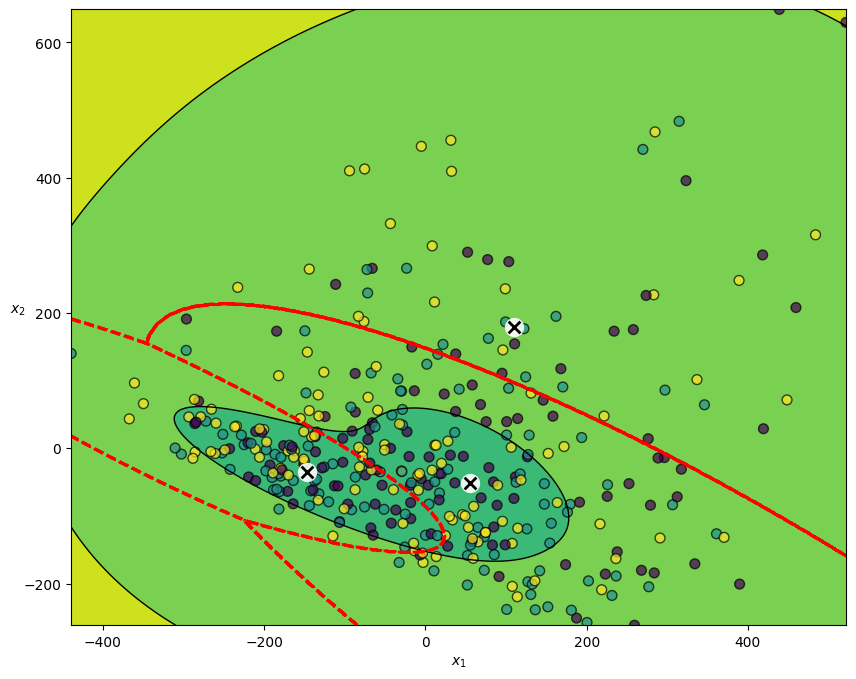

In [ ]:
plt.figure(figsize=(10, 8))
plot_gaussian_mixture(gmm1,images_2d,labels)
plt.show()

C.Use the model to generate 20 new rocks (using the sample() method), and visualize them in the original image space (since you used PCA, you will need to use its inverse_transform() method).  [4 points]

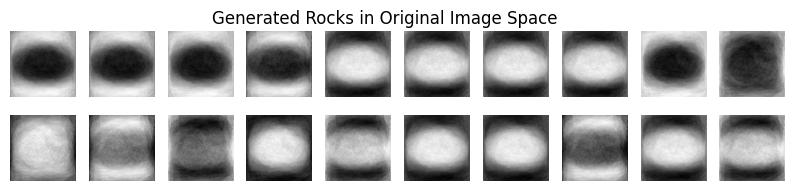

In [ ]:
new_samples, _ = gmm.sample(20)

# Use PCA's inverse_transform to map the samples back to the original space
original_space_samples = pca2.inverse_transform(new_samples)

def plot_images(images, title):
    plt.figure(figsize=(10, 2))
    for i in range(images.shape[0]):
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].reshape(image_shape), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Assuming 'image_shape' is the shape of your original images
image_shape = (400, 400, 1)

plot_images(original_space_samples, title='Generated Rocks in Original Image Space')

Above are the generated 20 sample image of rocks

7.Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers (we suggest using Keras (within Tensorflow) or Pytorch). Train the network to classify on 360 rock images using rock name as the label - the category is indicated by the first letter in the filename (I, M and S). Use images from '120 Rocks' folder as your validation data. Choose the number of neurons you find appropriate and efficient (so you have enough time to run it), but make the last layer before the softmax should consist of 8 neurons. The hidden layers should have ReLU activation function. Train the network for multiple epochs until it converges (if the process is too slow, tweak the learning rate and consider simplifying your network). We will not deduct points based on the simplicity of your network, but we expect you to have performance that is above chance performance that could be obtained with an untrained network - in other words, we expect to see train and validation loss decrease and accuracy increase throughout the training. We recommend using Colab (the free version should be totally fine), but make sure to run it with a GPU to speed up the training - to add a GPU on Colab go to Edit->Notebook settings).

In [ ]:
pip install tensorflow

In [2]:
import time
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_images_NN(folder_path):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_path, filename))
            label = filename[0]  # Extract first character which helps classifies the rocks
            img = cv2.resize(img, (400, 400))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
#define path for both train and validation data
train_data_dir = '/content/drive/My Drive/360 Rocks'
validation_data_dir = '/content/drive/My Drive/120 Rocks'

In [ ]:
X_train, y_train = load_images_NN(train_data_dir)
X_val, y_val = load_images_NN(validation_data_dir)

In [ ]:
# Convert images to grayscale
gray_images = convert_to_gray(X_train)

# Standardize the grayscale images
X_train = standardize_data(gray_images)

# Convert images to grayscale
gray_images = convert_to_gray(X_val)

# Standardize the grayscale images
X_val = standardize_data(gray_images)

In [ ]:
# scaling it btw 0-1, we divide it by 255 as its the max value for a pixel
X_train = X_train / 255.0
X_val = X_val / 255.0

In [ ]:
!pip install utils

In [ ]:
!pip install keras.utils

  Preparing metadata (setup.py) ... done
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2632 sha256=033aae0d219f417b5266627ef09982043596bc932220de6e39248f7d79b2b6a9
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras.utils


In [ ]:
# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# convert to one_hot
y_train_one_hot = to_categorical(y_train_encoded, num_classes=3)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=3)

In [4]:
#define height,width and channel
height,width,channels=400,400,1

In [5]:
# neural network model
from keras import regularizers
model = models.Sequential()
model.add(layers.Flatten(input_shape=(height, width, channels)))
model.add(layers.Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(layers.Dense(25, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(layers.Dense(8, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(layers.Dense(3, activation='softmax'))#last output layer has 3 neurons as it as 3 classes

The simple feedforward neural network has
1. One Flatten layer
2. Thre hidden Dense layers with ReLU activation with l2 regularization
3. Output Dense layer with softmax activation for multi-class classification. Output layer with 8 neurons for 8 categories

In [ ]:
start_time = time.time()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_one_hot,
                    validation_data=(X_val, y_val_one_hot),
                    epochs=30, batch_size=32)
# Record the end time
end_time = time.time()

Epoch 1/30
12/12 [==============================] - 3s 134ms/step - loss: 226.7764 - accuracy: 0.1972 - val_loss: 111.4893 - val_accuracy: 0.3250
Epoch 2/30
12/12 [==============================] - 1s 65ms/step - loss: 84.8864 - accuracy: 0.3028 - val_loss: 48.0607 - val_accuracy: 0.3833
Epoch 3/30
12/12 [==============================] - 1s 76ms/step - loss: 66.9343 - accuracy: 0.3833 - val_loss: 61.9021 - val_accuracy: 0.3417
Epoch 4/30
12/12 [==============================] - 1s 63ms/step - loss: 57.0172 - accuracy: 0.3833 - val_loss: 68.9375 - val_accuracy: 0.3333
Epoch 5/30
12/12 [==============================] - 1s 83ms/step - loss: 51.9695 - accuracy: 0.4028 - val_loss: 39.8019 - val_accuracy: 0.3667
Epoch 6/30
12/12 [==============================] - 1s 93ms/step - loss: 39.5477 - accuracy: 0.3833 - val_loss: 42.5486 - val_accuracy: 0.3417
Epoch 7/30
12/12 [==============================] - 1s 100ms/step - loss: 32.4783 - accuracy: 0.4639 - val_loss: 29.1407 - val_accuracy: 0.

A.Report the training time (use code to do this). [1 point]

In [ ]:
# Calculate and print the training time
training_time_seconds = end_time - start_time
print(f"Training time: {training_time_seconds} seconds")

Training time: 43.811609983444214 seconds


Total time taken for training the neuralnet is 43 sec

B.Plot training and validation loss and accuracy as a function of training epochs. [13 points]

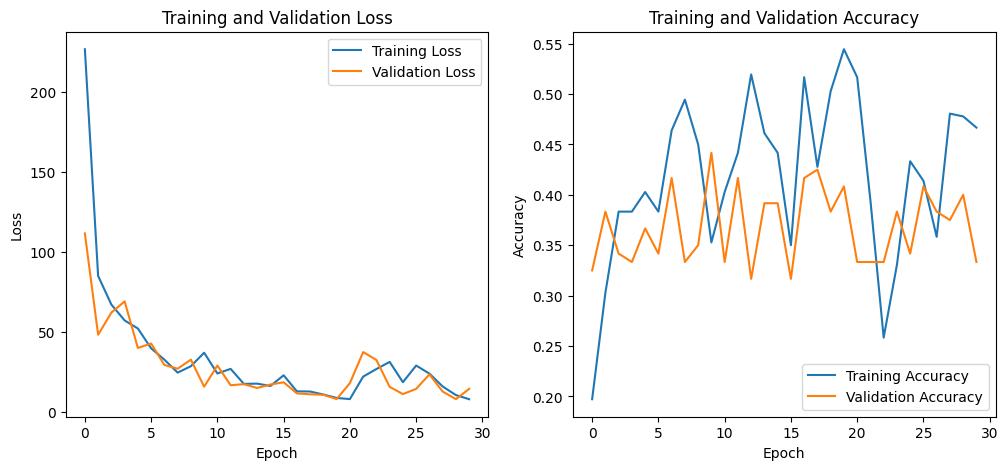

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Observation:</br>
a. Training and validation Loss</br>
The training and validation losses gradually decreases as the epochs increases showing that the model is learning to fit the training data,indicating effective learning.</br>
b. Training and validation accuracy</br>
Training accuracy is increasing.The gap between the training and validation is optimal we can conclude that the model is neither overfitting or underfitting

How many parameters does the network have? How many of those parameters are bias parameters? [1 points]

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 480000)            0         
                                                                 
 dense (Dense)               (None, 100)               48000100  
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 8)                 208       
                                                                 
 dense_4 (Dense)             (None, 3)                 27        
                                                                 
Total params: 48006660 (183.13 MB)
Trainable params: 4

C.1 How many parameters does the network have?
* Total parameters: 48006660
* Trainable parameters: 48006660
* Non-trainable parameters: 0</br>

C.2 How many of those parameters are bias parameters?</br>
Bias terms included in the Dense layers of your model by default.Bias parameters is 100 + 50 +25+ 8 + 3 = 186

D.Compare the activity of neurons in the next to the last layer (the one with 8 neurons) with the human data. (to get human data use mds_360.txt and mds_120.txt files). Similar to before, use Procrustes analysis to do the comparison.  For training and validation data (separately), report disparity and compute the correlation coefficient between each dimension of mtx1 and mtx2. Display results in a table. [3 points]

In [ ]:
#mds_360 file after standardization,pcs,converting to df
pca_df

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    0.148973 -0.271543 -0.210174 -0.056461 -0.013740 -0.226502  0.241761   
1   -0.366037 -0.040398 -0.175295  0.003709 -0.145708 -0.330163  0.169538   
2    0.107073  0.087783 -0.236575  0.146396 -0.162892  0.079627 -0.214500   
3   -0.196952 -0.023984 -0.031455 -0.124897  0.039050 -0.206395 -0.208329   
4   -0.215349 -0.183331 -0.382941  0.063815  0.054252  0.138522 -0.241435   
..        ...       ...       ...       ...       ...       ...       ...   
355  0.200942  0.237105  0.128021 -0.394985 -0.193296 -0.128676 -0.143873   
356  0.198905 -0.006845  0.108523 -0.285493  0.202301  0.141416 -0.230530   
357  0.365727  0.123286 -0.204908 -0.128429 -0.039306 -0.075794 -0.024804   
358 -0.118309  0.165029  0.313258 -0.358635 -0.138134  0.098369 -0.020646   
359 -0.069406  0.372758  0.188575 -0.294569 -0.012419 -0.204090 -0.022395   

          PC8  
0    0.044887  
1   -0.170192  
2   -0.339811  
3   -0.219381  
4   -0.127352  
..        ...  
355 -0.009849  
356 -0.051224  
357 -0.087695  
358  0.240452  
359  0.147340  

[360 rows x 8 columns]

In [ ]:
dataset_path2 = '/content/drive/My Drive/mds_120.txt'
#read data
mds_features_120 = np.loadtxt(dataset_path2)
#print(mds_features_120)
print("size:",mds_features_120.shape)

size: (120, 8)


In [ ]:
#scale it
scaled_features2 = scaler.fit_transform(mds_features_120)

#PCA
pca4 = PCA(n_components=8)
pca4_result = pca4.fit_transform(scaled_features2)

# Check if the dimensionality is 360, 8
print("Size:",pca4_result.shape)
import pandas as pd
pca_df_120 = pd.DataFrame(data=pca4_result, columns=[f'PC{i}' for i in range(1, 9)])

Size: (120, 8)


In [ ]:
# Extract activations from the next-to-last layer for training data
train_activations = model.layers[-2].output

def activations_fn(inputs):
    return model(inputs, training=False)

train_predictions = model.predict(X_train)
train_activations = activations_fn(X_train)

train_mtx1, train_mtx2, train_disparity = procrustes(pca_df, train_activations)

train_correlations = [pearsonr(train_mtx1[:, i], train_mtx2[:, i])[0] for i in range(train_mtx1.shape[1])]

#validation data
val_predictions = model.predict(X_val)
val_activations = activations_fn(X_val)

val_mtx1, val_mtx2, val_disparity = procrustes(pca_df_120, val_activations)
val_correlations = [pearsonr(val_mtx1[:, i], val_mtx2[:, i])[0] for i in range(val_mtx1.shape[1])]

results_table = pd.DataFrame({
    'Data': ['Training', 'Validation'],
    'Disparity': [train_disparity, val_disparity],
    'Correlation Dimension 1': [train_correlations[0], val_correlations[0]],
    'Correlation Dimension 2': [train_correlations[1], val_correlations[1]],
})

print(results_table)


4/4 [==============================] - 0s 35ms/step
         Data  Disparity  Correlation Dimension 1  Correlation Dimension 2
0    Training   0.996372                 0.045406                 0.008800
1  Validation   0.991894                 0.035821                 0.050883


The Neural network shows a better score in term of disparity than the above methods have disparity around 0.99

In [ ]:
print("Shape of pca_df_120:", pca_df_120.shape)
print("Shape of val_activations:", val_activations.shape)

Shape of pca_df_120: (360, 8)
Shape of val_activations: (120, 8)
